## Lab assignment 02

In [28]:
import os
from typing import Iterable, List
import unicodedata
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy 

import numpy as np
import random
import math
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import WordPunctTokenizer
from torchtext.vocab import vocab as Vocab
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm, trange
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE

#### Constants:

In [29]:
# constants
class config:
    FILE = './data.txt'
    SOS_token = 0
    EOS_token = 1
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    EPOCHS = 20
    CLIP = 1
    MAX_LENGTH = 0
    BATCH_SIZE = 32

In [30]:
#!wget -qO- https://github.com/Z5-05/nlp_made_2023/raw/main/labs/lab_2/archives/dataset.tar.gz | tar xvz

if not os.path.exists(config.FILE):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

In [31]:
%%time
df = pd.read_csv(
    "data.txt", sep="\t", lineterminator="\n", header=None, names=['en', 'ru']
)

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_data, valid_data = train_df.values, valid_df.values

CPU times: user 199 ms, sys: 36 ms, total: 235 ms
Wall time: 243 ms


In [32]:
tokenizer = WordPunctTokenizer()

def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())

In [33]:
src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)
trg_vocab = Vocab(trg_counter, min_freq=2)

In [34]:
unk_token = "<unk>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

In [35]:
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

In [36]:
print(f"Unique tokens in source (en) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (ru) vocabulary: {len(trg_vocab)}")

Unique tokens in source (en) vocabulary: 10126
Unique tokens in target (ru) vocabulary: 14116


In [37]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [38]:
def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)[::-1]
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


train_dataloader = DataLoader(train_data, config.BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(valid_data, config.BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader), 1)
src_batch.shape, trg_batch.shape

(torch.Size([39, 32]), torch.Size([38, 32]))

In [39]:
# get max sequence size
config.MAX_LENGTH = max(config.MAX_LENGTH, max([i[0].size(0) for i in train_dataloader]))
config.MAX_LENGTH = max(config.MAX_LENGTH, max([i[0].size(0) for i in val_dataloader]))

In [40]:
class Encoder(nn.Module):
    def __init__(self, n_tokens, hid_dim, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(n_tokens, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hid_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded)

        return output, hidden
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, n_tokens, hid_dim, dropout, max_length=config.MAX_LENGTH):
        super().__init__()
        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(n_tokens, hid_dim)
        self.attn = nn.Linear(hid_dim * 2, max_length)
        self.attn_combine = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hid_dim, hid_dim)
        self.out = nn.Linear(hid_dim, n_tokens)
    
    def forward(self, input, hidden, encoder_outputs):
        input = input.view(1, -1)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        output = torch.cat((embedded[0], attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output, hidden = self.gru(output, hidden)
        pred = self.out(output.squeeze(dim=0))

        return pred, hidden, attn_weights

In [41]:
import random


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        src_len = src.shape[0]
        trg_len = trg.shape[0]
        
        trg_vocab_size = self.decoder.n_tokens
        
        preds = []
        
        output, hidden = self.encoder(src)
        encoder_outputs = torch.zeros(batch_size, config.MAX_LENGTH, self.encoder.hid_dim, device=config.DEVICE)
        encoder_outputs[:, :output.size(0), :] = output.view(batch_size, -1, self.encoder.hid_dim)

        input = trg[0, :]

        for i in range(1, trg_len):
            pred, hidden, attention = self.decoder(input, hidden, encoder_outputs)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = Encoder(len(src_vocab),  hid_dim=256, dropout=0.5)
dec = AttnDecoderRNN(len(trg_vocab), hid_dim=256, dropout=0.5)
model = Seq2Seq(enc, dec).to(device)

In [43]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model = model.apply(init_weights)

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,806,409 trainable parameters


In [45]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

In [46]:
train_losses = []
val_losses = []
train_times = []
val_times = []


for epoch in trange(config.EPOCHS, desc="Epochs"):
    model.train()
    train_loss = 0
    for src, trg in tqdm(train_dataloader, desc="Train", leave=False, position=0):
        start_time = time.time()
        src, trg = src.to(config.DEVICE), trg.to(config.DEVICE)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), config.CLIP)
        optimizer.step()

        train_loss += loss.item()
        end_time = time.time()
        train_times.append(end_time - start_time)

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_dataloader, desc="Val", leave=False, position=0):
            start_time = time.time()
            src, trg = src.to(config.DEVICE), trg.to(config.DEVICE)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)

            val_loss += loss.item()
            end_time = time.time()
            val_times.append(end_time - start_time)

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train:  35%|███▌      | 443/1250 [00:37<01:05, 12.26it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Train:  95%|█████████▍| 1185/1250 [01:42<00:05, 11.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [47]:
def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]

def get_text(x, trg_vocab):
    text = [trg_vocab.lookup_token(token) for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

In [48]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(val_dataloader)):

        src = batch[0].to(config.DEVICE)
        trg = batch[1].to(config.DEVICE)

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, trg_vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, trg_vocab) for x in output[1:].detach().cpu().numpy().T])

313it [00:10, 28.46it/s]


### Analyse results:

In [49]:
print(f"BLEU result: {corpus_bleu([[text] for text in original_text], generated_text) * 100}")

BLEU result: 17.136739802760065


In [50]:
print(f"Total training time // Avg time on epoch //  Avg time on batch: {sum(train_times)}, {sum(train_times)/config.EPOCHS}, {np.mean(train_times)}")

Total training time // Avg time on epoch //  Avg time on batch: 2057.92928147316, 102.896464073658, 0.08231717125892639


In [51]:
print(f"Total eval time // Avg time on epoch //  Avg time on batch: {sum(val_times)}, {sum(val_times)/config.EPOCHS}, {np.mean(val_times)}")

Total eval time // Avg time on epoch //  Avg time on batch: 184.81501936912537, 9.240750968456268, 0.029523166033406607


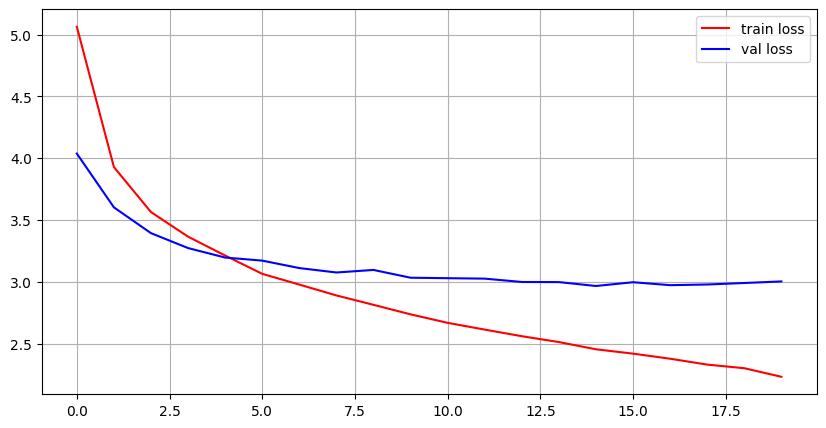

In [52]:
x = range(config.EPOCHS)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(x, train_losses, 'r', label='train loss')
plt.plot(x, val_losses, 'b', label='val loss') 
plt.legend()
plt.grid()
plt.show()

In [53]:
diff = np.array(val_losses) - np.array(train_losses)
mean_uplift = np.mean(100 * (diff[1:] - diff[:-1]) / diff[:-1])

print(f"Avg uplift of diff between train and val = {mean_uplift}")

Avg uplift of diff between train and val = -40.942947847596265


In [54]:
print("Example of best-translated sentenses:")
print("------------------------------------")
i = 0
for orig, gen in zip(original_text, generated_text):
    if set(orig) == set(gen):
        i += 1
        print(f"\t{i}) Original: {' '.join(orig)}")
        print(f"\t{i}) Generated: {' '.join(gen)}")
    if i == 10:
        break

Example of best-translated sentenses:
------------------------------------
	1) Original: предоставляются полотенца и постельное белье .
	1) Generated: предоставляются полотенца и постельное белье .
	2) Original: предоставляется постельное белье .
	2) Generated: предоставляется постельное белье .
	3) Original: предоставляются полотенца и постельное белье .
	3) Generated: предоставляются полотенца и постельное белье .
	4) Original: в отеле можно поиграть в бильярд .
	4) Generated: отеле можно поиграть в бильярд .
	5) Original: предоставляются полотенца и постельное белье .
	5) Generated: предоставляются полотенца и постельное белье .
	6) Original: номера оснащены телевизором с плоским экраном .
	6) Generated: номера оснащены телевизором с плоским экраном .
	7) Original: предоставляются полотенца и постельное белье .
	7) Generated: предоставляются полотенца и постельное белье .
	8) Original: номера оснащены телевизором с плоским экраном и спутниковыми каналами .
	8) Generated: номера осна

In [55]:
print("Example of worst-translated sentenses:")
print("------------------------------------")
i = 0
for orig, gen in zip(original_text, generated_text):
    if len(set(orig).intersection(set(gen))) == 1:
        i += 1
        print(f"\t{i}) Original: {' '.join(orig)}")
        print(f"\t{i}) Generated: {' '.join(gen)}")
    if i == 10:
        break

Example of worst-translated sentenses:
------------------------------------
	1) Original: также гостям предлагаются различные виды массажа .
	1) Generated: предоставляются услуги .
	2) Original: в 4 барах каждый вечер устраивают концерты живой музыки , а на транслируются спортивные мероприятия .
	2) Generated: и .
	3) Original: ванная комната оборудована душем .
	3) Generated: ванной комнате установлен душ .
	4) Original: на частном пляже отеля предлагаются бесплатные безалкогольные напитки .
	4) Generated: мини - гостинице могут бесплатно пользоваться велосипедами .
	5) Original: на территории курортного отеля обустроена большая детская игровая площадка .
	5) Generated: отеле гостей обустроен тренажерный зал .
	6) Original: рядом с хостелом находится автобусная .
	6) Generated: отеля можно найти прямо напротив входа .
	7) Original: для гостей сервируют восточный и западный завтраки .
	7) Generated: отеле подают американский завтрак .
	8) Original: комплекс casale размещается на террит